# 종합실습과제2. Scale불량 급증의 근본 원인을 찾고 불량 예측 및 개선 기회 도출

In [3]:
#목표변수와 연속형 설명변수 관계 확인(히스토그램)
def fun_plot_hist(data, var):
    plt.title(var)
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha=0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha=0.5)
    plt.legend()
#=================

#목표변수와 범주형 설명변수 관계 확인(교차표)
def fun_print_crosstab(data, var):
    print(pd.crosstab(index= data["scale"], columns=data[var]))
    print()
    print(pd.crosstab(index= data["scale"], columns=data[var], normalize= "columns").round(3))

In [4]:
#데이터 구성:Series,DataFrame
import pandas as pd
#데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

#데이터 scaling
from sklearn.preprocessing import StandardScaler
#분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier
#분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
#분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
#분류 NN
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report



#모델 성능 평가 함수
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,auc
matplotlib.rc("font", family = "NanumGothic")
# 유니코드 깨짐현상 해결
matplotlib.rc("axes", unicode_minus = False)

#오류 텍스트 제거
import warnings
warnings.filterwarnings(action='ignore')

df_raw=pd.read_csv("SCALE불량.csv", encoding="euc-kr")
#df_raw의 데이터 갯수와 columns 출력
print("shpae: ", df_raw.shape)
df_raw.head()

shpae:  (1000, 22)


,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


### 후판제품의 "Scale불량급증" => 압연흠, scratch외 압연공정에서 급증.
#### 후판공정 순서 : 가열 -> 스케일 제거 -> 사상압연 -> 사전교정 -> 가속냉각
#### Scale이란? 철 표면에 생기는 산화물 층, but)Scale이 많아지면 품질저하, 표면처리 작업을 어렵게 만든다.




### 압연공정에서 scale불량이 급증한 이유 
#### 1. 공정조건 : 압연 기계에서 온도, 압력, 습도, 속도 등의 조건을 정확히 조절하지 않기 때문이다. 특히 과도한 열 또는 고온에서 압연을 하면 표면에 scale이 형성된다.
#### 2. 원자재 품질 : 철강 및 다른 금속 원자재의 품질이 낮을경우 발생, 강도,석출물,내식성, 오염등으로 발생한다.
#### 3. 용융처리 : 성분 조절이나 청정성 처리 등의 문제 발생, 이러한 문제는 슬래그, 내층 결합, 녹슬음을 발생시킨다.

## 변수 설명

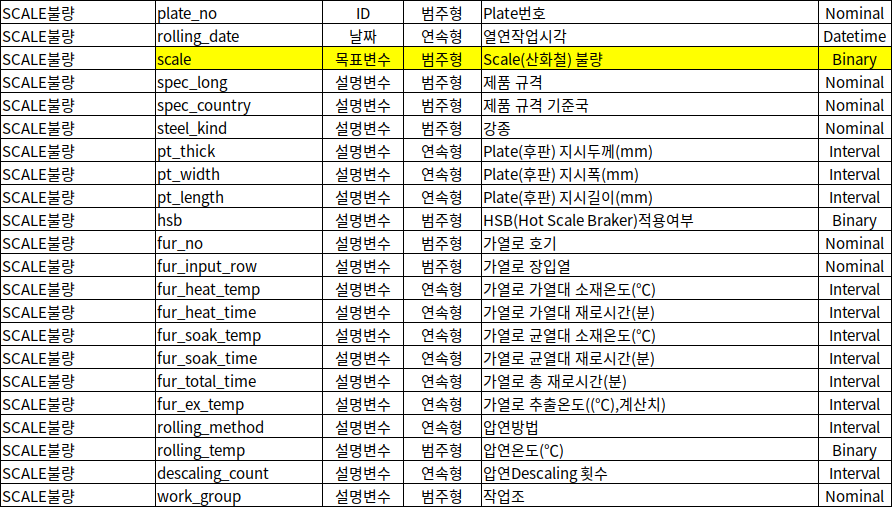

### 내가 생각했을때 plat_no , rolling_data, spec_long, spec_country는 scale과는 상관 없다고 생각하여 설명변수에서 제거하였다
### 범주형 : ID, scale, spec_long, spec_country, steel_kind, hsb, fur_no, fur_input_row ,rolling_temp, work_group
### 연속형 : fur_heat_temp, fur_soak_temp, fur_soak_time, fur_total_time,  fur_ex_temp, rolling_method, descaling_count

## Plate(후판)의 지시두께, 지시폭, 지시길이 등은 제품의 규격에 관한 정보이며, Plate(후판)의 불량 발생과 직접적인 연관성은 없다.
## HSB(Hot Scale Breaker)의 적용 여부는 Scale 제거에 관한 변수로, HSB를 적용하지 않은 경우 Scale 불량이 발생할 수 있습니다. 따라서 HSB 적용 여부는 Scale 불량의 원인 중 하나로 생각한다
## 가열로의 호기, 장입열, 가열대 소재온도, 재로시간, 균열대 소재온도, 재로시간, 총 재로시간, 추출온도 등은 가열 과정과 관련된 변수이다.. 이들 변수 중 어느 하나라도 적절하지 않은 값이 설정된 경우, Scale 불량이 발생할 수 있다.
## 압연방법, 압연온도, 압연Descale(스케일 제거) 횟수, 작업조 등은 압연 과정과 관련된 변수들이다. 이들 변수 중 어느 하나라도 적절하지 않은 값이 설정된 경우, Scale 불량이 발생할 수 있다.

In [24]:
#df_raw.drop(['plate_no', 'rolling_date', 'spec_long', 'spec_country'], axis=1 , inplace=False) 
#plat_no , rolling_data, spec_long, spec_country 삭제하고 일단 정보를 저장하지 않는다.
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scale            1000 non-null   object
 1   steel_kind       1000 non-null   object
 2   pt_thick         1000 non-null   int64 
 3   pt_width         1000 non-null   int64 
 4   pt_length        1000 non-null   int64 
 5   hsb              1000 non-null   object
 6   fur_no           1000 non-null   object
 7   fur_input_row    1000 non-null   object
 8   fur_heat_temp    1000 non-null   int64 
 9   fur_heat_time    1000 non-null   int64 
 10  fur_soak_temp    1000 non-null   int64 
 11  fur_soak_time    1000 non-null   int64 
 12  fur_total_time   1000 non-null   int64 
 13  fur_ex_temp      1000 non-null   int64 
 14  rolling_method   1000 non-null   object
 15  rolling_temp     1000 non-null   int64 
 16  descaling_count  1000 non-null   int64 
 17  work_group       1000 non-null   o

In [18]:
df_raw
#삭제된 값 확인

,scale,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,양품,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,양품,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,양품,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,양품,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,양품,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,양품,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,203,1151,CR(제어압연),948,10,4조
996,양품,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,209,1151,CR(제어압연),948,10,4조
997,양품,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,227,1163,CR(제어압연),948,10,4조
998,양품,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,204,1163,CR(제어압연),948,10,4조


In [16]:
#결측치 확인 : 결측치 없음
df_raw.isnull().sum()
#결측치 없음

scale              0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
fur_ex_temp        0
rolling_method     0
rolling_temp       0
descaling_count    0
work_group         0
dtype: int64

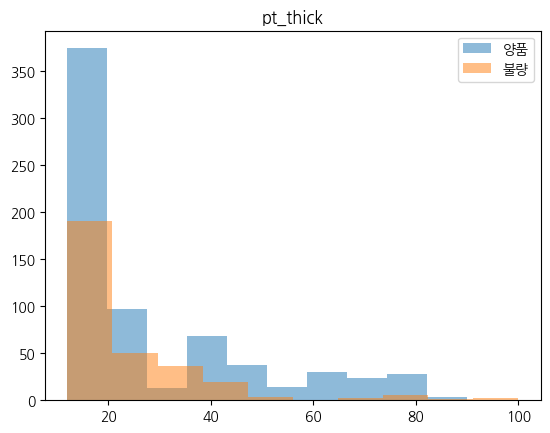

In [27]:
#fun_plot_hist사용법, pt_thick histogram으로 뽑기.
fun_plot_hist(df_raw, 'pt_thick') 

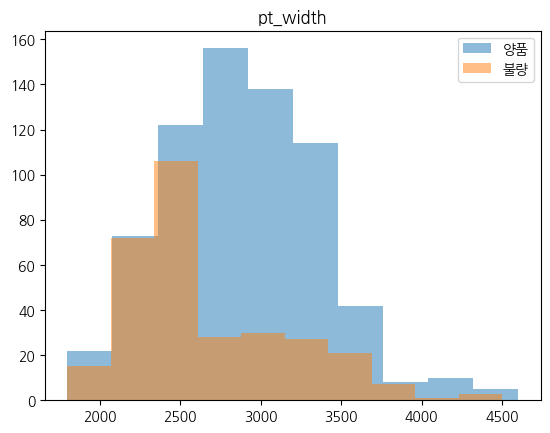

In [29]:
#fun_plot_hist사용법, pt_width histogram으로 뽑기.
fun_plot_hist(df_raw, 'pt_width') 

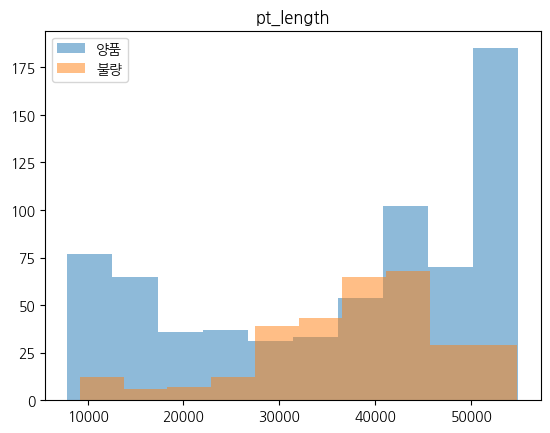

In [30]:
#fun_plot_hist사용법, pt_length histogram으로 뽑기.
fun_plot_hist(df_raw, 'pt_length') 

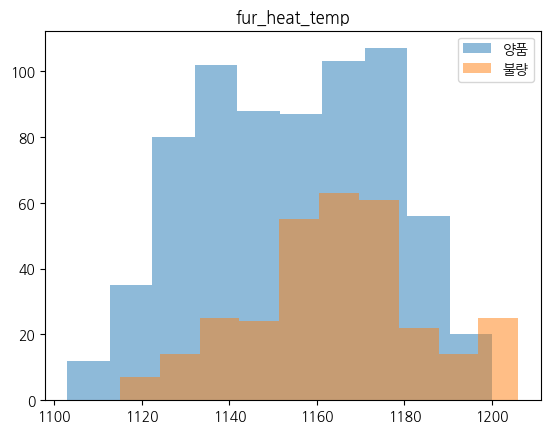

In [40]:
#fun_plot_hist사용법, fur_heat_temp histogram으로 뽑기.
fun_plot_hist(df_raw, "fur_heat_temp") 

### fur_heat_temp(가열대 소재온도)가 1200도가 넘어가면 불량률이 100%이다. VF로 의심

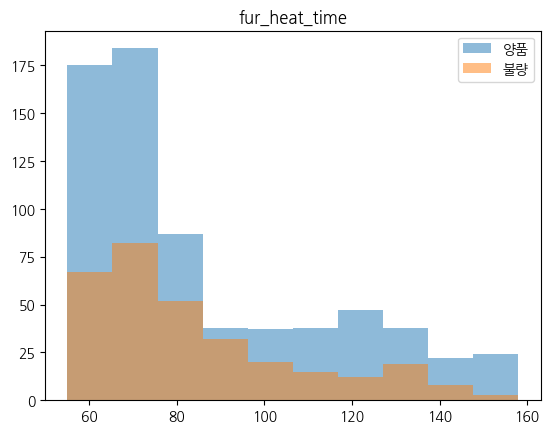

In [41]:
#fun_plot_hist사용법, fur_heat_time histogram으로 뽑기.
fun_plot_hist(df_raw, "fur_heat_time") 

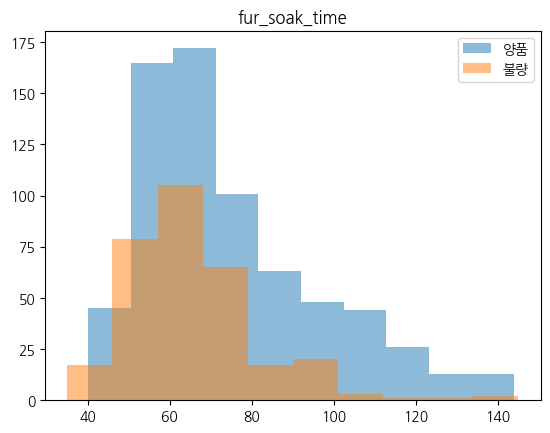

In [43]:
#fun_plot_hist사용법, fur_soak_time histogram으로 뽑기.
fun_plot_hist(df_raw, "fur_soak_time") 

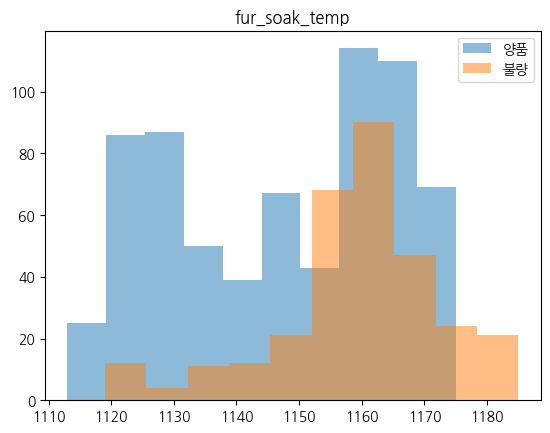

In [49]:
#fun_plot_hist사용법, fur_soak_temp histogram으로 뽑기.
fun_plot_hist(df_raw, "fur_soak_temp") 

### for_soak_temp가 1175가 넘으면 불량률이 100%이다. VF로 의심해볼만하다.

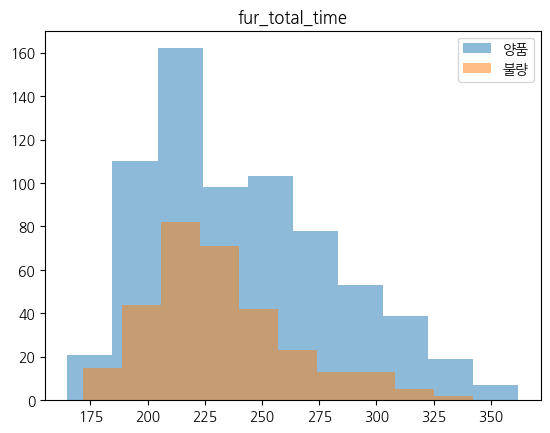

In [45]:
#fun_plot_hist사용법, fur_total_time histogram으로 뽑기.
fun_plot_hist(df_raw, "fur_total_time") 

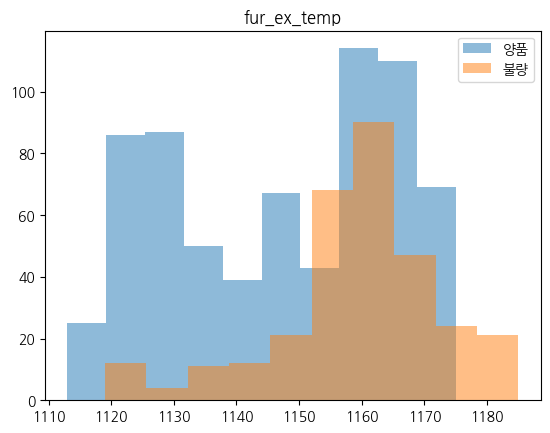

In [48]:
#fun_plot_hist사용법, fur_ex_time histogram으로 뽑기.
fun_plot_hist(df_raw, "fur_ex_temp") 

### for_soak_temp가 1175가 넘으면 불량률이 100%이다. VF로 의심해볼만하다.

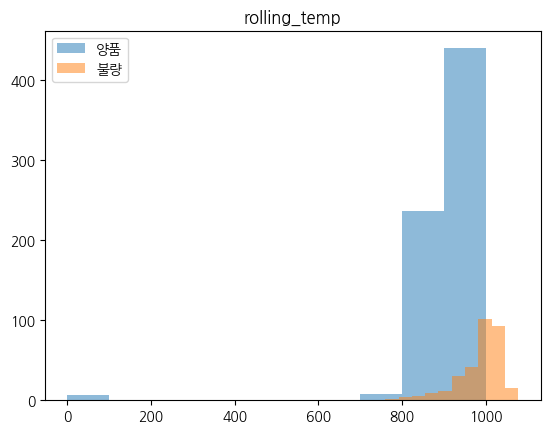

In [51]:
#fun_plot_hist사용법, rolling_temp histogram으로 뽑기.
fun_plot_hist(df_raw, "rolling_temp") 

### 1000도 이상일때는 불량률이 100%이다. VF일가능성이 높다. 또한 0~100사이에 데이터가 있으므로 이상치 확인 ->처리 or 삭제할것인지 정해야한다

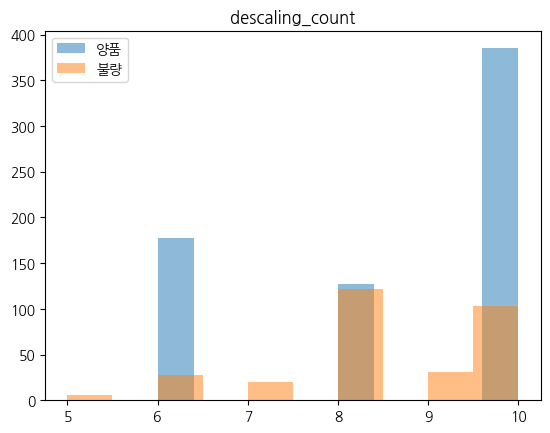

In [65]:
#fun_plot_hist사용법, descaling_count histogram으로 뽑기.
fun_plot_hist(df_raw, "descaling_count") 


### 5, 7, 9번에서는 불량품이 100%이다. 8번은 약 49%정도, 홀수마다 100%인 것은 어떤 이유가 있을까?

In [66]:
#fun_print_crosstab사용법, descaling_count 따라 scale인 양품,불량률 확인
fun_print_crosstab(df_raw, "descaling_count")

descaling_count  5    6   7    8   9    10
scale                                     
불량                6   28  20  122  31  103
양품                0  178   0  127   0  385

descaling_count   5      6    7     8    9      10
scale                                             
불량               1.0  0.136  1.0  0.49  1.0  0.211
양품               0.0  0.864  0.0  0.51  0.0  0.789


In [61]:
#fun_print_crosstab사용법, steel_kind에 따라 scale인 양품,불량률 확인
fun_print_crosstab(df_raw, "steel_kind")

steel_kind    C    T
scale               
불량          290   20
양품          465  225

steel_kind      C      T
scale                   
불량          0.384  0.082
양품          0.616  0.918


In [62]:
#fun_print_crosstab사용법,hsb 에 따라 scale인 양품,불량률 확인
fun_print_crosstab(df_raw, "hsb")

hsb    미적용   적용
scale          
불량      47  263
양품       0  690

hsb    미적용     적용
scale            
불량     1.0  0.276
양품     0.0  0.724


### HSB미적용했을 시 불량이 100%가 나오므로 VF일 가능성이 높다

In [59]:
#fun_print_crosstab사용법   fur_no에 따라 scale인 양품,불량률 확인
fun_print_crosstab(df_raw, "fur_no")

fur_no  1호기  2호기  3호기
scale                
불량      101   92  117
양품      232  233  225

fur_no    1호기    2호기    3호기
scale                      
불량      0.303  0.283  0.342
양품      0.697  0.717  0.658


In [58]:
#fun_print_crosstab사용법   fur_input_row에 따라 scale인 양품,불량률 확인
fun_print_crosstab(df_raw, "fur_input_row")


fur_input_row   1열   2열
scale                  
불량             165  145
양품             343  347

fur_input_row     1열     2열
scale                      
불량             0.325  0.295
양품             0.675  0.705


In [64]:
#fun_print_crosstab사용법 work_group 에 따라 scale인 양품,불량률 확인
fun_print_crosstab(df_raw, "work_group") 

work_group   1조   2조   3조   4조
scale                         
불량          109   85   66   50
양품          171  207  152  160

work_group     1조     2조     3조     4조
scale                                 
불량          0.389  0.291  0.303  0.238
양품          0.611  0.709  0.697  0.762


### 각 조마다 불량률이 낮다. 1조>3조>2조>4조. 근무 환경이 불량률에 영향을 끼치는지?

In [57]:
#fun_print_crosstab사용법, work_group에 따라 scale인 양품,불량률 확인
fun_print_crosstab(df_raw, "rolling_method")

rolling_method  CR(제어압연)  TMCP(온도제어)
scale                               
불량                   297          13
양품                   543         147

rolling_method  CR(제어압연)  TMCP(온도제어)
scale                               
불량                 0.354       0.081
양품                 0.646       0.919


In [56]:
#fun_print_crosstab사용법, work_group에 따라 scale인 양품,불량률 확인
fun_print_crosstab(df_raw, "work_group")

work_group   1조   2조   3조   4조
scale                         
불량          109   85   66   50
양품          171  207  152  160

work_group     1조     2조     3조     4조
scale                                 
불량          0.389  0.291  0.303  0.238
양품          0.611  0.709  0.697  0.762
